# Pneumonia Lung X-Ray Detection

Training images: 136 Validation images: 40
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 mobilenetv2_1.00_224 (Func  (N

Epoch 1/20
5/5 [==============================] - 2s 258ms/step - loss: 13.3657 - accuracy: 0.4189 - val_loss: 1.3361 - val_accuracy: 0.6500
Epoch 2/20
5/5 [==============================] - 1s 186ms/step - loss: 2.1034 - accuracy: 0.7027 - val_loss: 4.3409 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 1s 185ms/step - loss: 3.9040 - accuracy: 0.5203 - val_loss: 0.8809 - val_accuracy: 0.9000
Epoch 4/20
5/5 [==============================] - 1s 187ms/step - loss: 3.0175 - accuracy: 0.6216 - val_loss: 0.8393 - val_accuracy: 0.9000
Epoch 5/20
5/5 [==============================] - 1s 189ms/step - loss: 0.0979 - accuracy: 0.9797 - val_loss: 0.5002 - val_accuracy: 0.9000
Epoch 6/20
5/5 [==============================] - 1s 192ms/step - loss: 0.6846 - accuracy: 0.8716 - val_loss: 0.9262 - val_accuracy: 0.8500
Epoch 7/20
5/5 [==============================] - 1s 195ms/step - loss: 0.8175 - accuracy: 0.8716 - val_loss: 0.2894 - val_accuracy: 0.9500
Epoch 8/20
5/5 [===

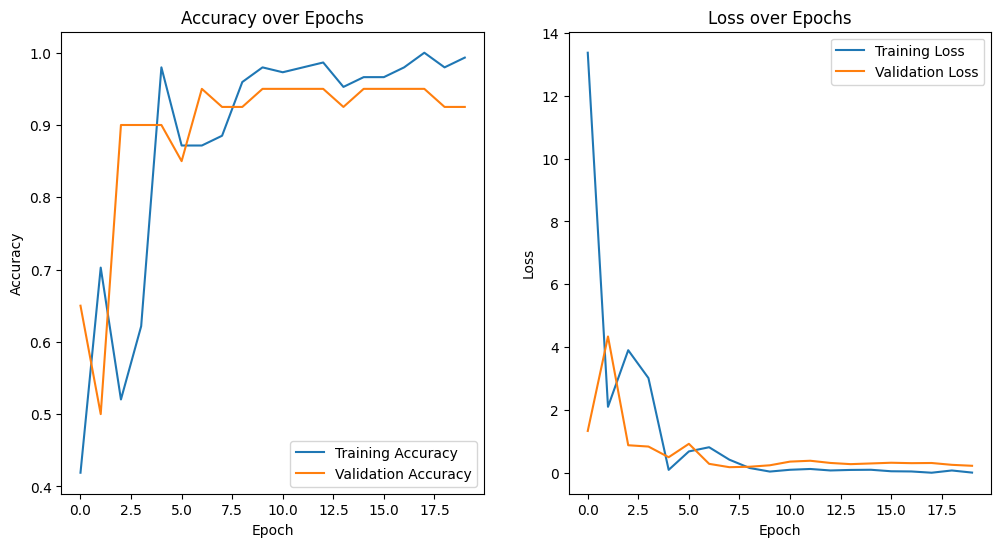

1/1 [==============================] - 0s 361ms/step


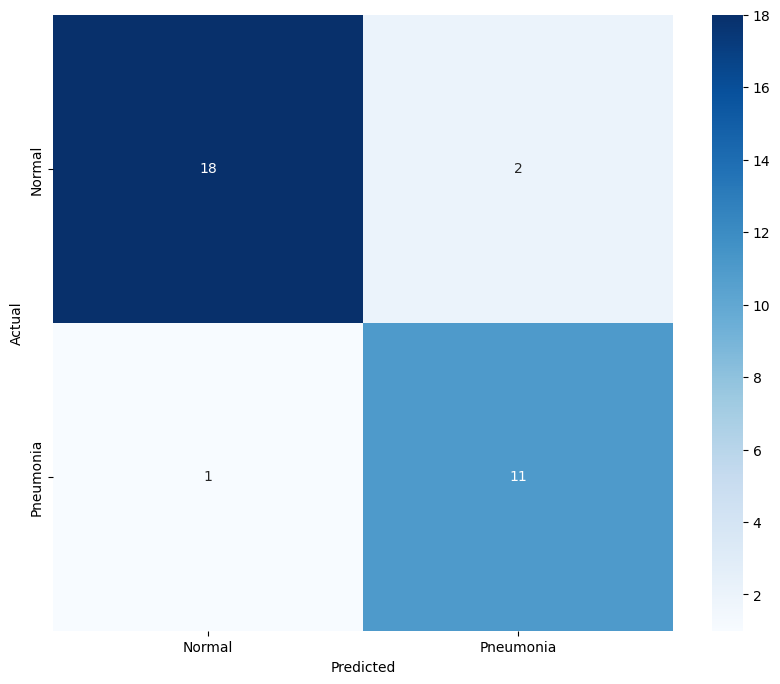

In [15]:
import numpy as np
import tensorflow as tf
import pathlib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the paths for training and validation data
train_normal_dir = '/Users/jessemaki/Downloads/xray_disease_detection/train/NORMAL'
train_pneumonia_dir = '/Users/jessemaki/Downloads/xray_disease_detection/train/PNEUMONIA'
valid_normal_dir = '/Users/jessemaki/Downloads/xray_disease_detection/test/NORMAL'
valid_pneumonia_dir = '/Users/jessemaki/Downloads/xray_disease_detection/test/PNEUMONIA'

# Function to count images of both .jpg and .jpeg formats
def count_images(paths, extensions=['*.jpg', '*.jpeg']):
    total = 0
    for path in paths:
        path = pathlib.Path(path)
        total += sum([len(list(path.glob(ext))) for ext in extensions])
    return total


# Print number of training and validation images
train_image_count = count_images([train_normal_dir, train_pneumonia_dir])
valid_image_count = count_images([valid_normal_dir, valid_pneumonia_dir])
print('Training images:', train_image_count, 'Validation images:', valid_image_count)

# Ensure there are images before proceeding
if train_image_count == 0 or valid_image_count == 0:
    raise ValueError("No training/validation images found. Check your paths and file extensions.")

# Function to process the images and extract labels
def process_image(file_path):
    # Extract label from file path and assign numerical value
    label = tf.strings.split(file_path, os.sep)[-2]
    label = tf.where(label == 'NORMAL', 0, 1)
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # Resize to 224x224
    return img, label

# Preparing the training dataset
train_data = tf.data.Dataset.list_files(str(pathlib.Path(train_normal_dir) / '*'))
train_data = train_data.concatenate(tf.data.Dataset.list_files(str(pathlib.Path(train_pneumonia_dir) / '*')))
train_data = train_data.map(process_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Preparing the validation dataset
valid_data = tf.data.Dataset.list_files(str(pathlib.Path(valid_normal_dir) / '*'))
valid_data = valid_data.concatenate(tf.data.Dataset.list_files(str(pathlib.Path(valid_pneumonia_dir) / '*')))
valid_data = valid_data.map(process_image).batch(32).prefetch(tf.data.AUTOTUNE)

print(train_data, valid_data)

# Download pre-trained convolution network with the correct input shape
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),  # Correct input shape
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build complete model
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(224,224,3)),  # Add input_shape here
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    base_model,
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2, activation='softmax')  # Assuming 2 classes: NORMAL and PNEUMONIA
])

model.summary()

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Fit model only if there are training images and validation images
if train_image_count > 0 and valid_image_count > 0:
    history = model.fit(train_data, 
                        epochs=20, 
                        validation_data=valid_data)  # Include the validation data here

    # Plotting training and validation accuracy and loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Predict classes for the validation dataset
    valid_images, valid_labels = next(iter(valid_data))
    predictions = model.predict(valid_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute and plot confusion matrix
    cm = confusion_matrix(valid_labels.numpy(), predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("No sufficient images to train and validate.")
